# Pruebas rapidas del modulo de simulacion

Este cuaderno valida los flujos principales basados en REBOUND: creacion de simulaciones y estimacion de Lyapunov mediante MEGNO.


> Configuración del `sys.path` para ejecutar el notebook fuera de la raíz del repositorio.

In [14]:
import sys
from pathlib import Path

root = Path.cwd().resolve()
while root != root.parent:
    if (root / "simulation").is_dir():
        if str(root) not in sys.path:
            sys.path.insert(0, str(root))
        break
    root = root.parent
else:
    raise RuntimeError("No se encontró el paquete 'simulation'")

# Simulación

In [15]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from simulation.rebound_adapter import ReboundSim
from simulation.lyapunov import LyapunovEstimator

# Ajusta estos parámetros según el escenario que quieras probar
masses = (2.5, 2.5)                 # admite 2 o 3 masas
r0 = ((-1.0, 0.0, 0.0), (1.0, 0.0, 0.0))
v0 = ((0.0, -0.5, 0.0), (0.0, 0.5, 0.0))
dt = 0.5
t_end = 50.0

In [16]:
builder = ReboundSim(G=1.0, integrator="whfast")
sim = builder.setup_simulation(masses=masses, r0=r0, v0=v0)
traj = builder.integrate(sim.copy(), t_end=t_end, dt=dt)

steps, n_bodies, _ = traj.shape
time = (np.arange(steps, dtype=float) + 1.0) * dt
traj

array([[[-0.92104622, -0.24325595,  0.        ,  0.31919073,
         -0.45856   ,  0.        ],
        [ 0.92104622,  0.24325595,  0.        , -0.31919073,
          0.45856   ,  0.        ]],

       [[-0.67350929, -0.43928466,  0.        ,  0.68287777,
         -0.29698517,  0.        ],
        [ 0.67350929,  0.43928466,  0.        , -0.68287777,
          0.29698517,  0.        ]],

       [[-0.22189622, -0.48476583,  0.        ,  1.13658676,
          0.22973993,  0.        ],
        [ 0.22189622,  0.48476583,  0.        , -1.13658676,
         -0.22973993,  0.        ]],

       ...,

       [[ 0.21426552, -0.16664434,  0.        ,  0.76740678,
          1.73670504,  0.        ],
        [-0.21426552,  0.16664434,  0.        , -0.76740678,
         -1.73670504,  0.        ]],

       [[-0.16291308,  0.47033206,  0.        , -1.18115042,
          0.34087448,  0.        ],
        [ 0.16291308, -0.47033206,  0.        ,  1.18115042,
         -0.34087448,  0.        ]],

       

In [17]:
est = LyapunovEstimator()
ctx = {"sim": sim, "dt": dt, "t_end": t_end, "masses": masses}
lyap = est.mLCE(ctx, window=t_end)

lam = lyap["lambda"]
series = lyap["series"]
meta = lyap["meta"]
lam, meta

(0.0238574484452133,
 {'steps': 100,
  'dt': 0.5,
  'n_bodies': 2,
  'masses': (2.5, 2.5),
  'impl': 'rebound_megno'})

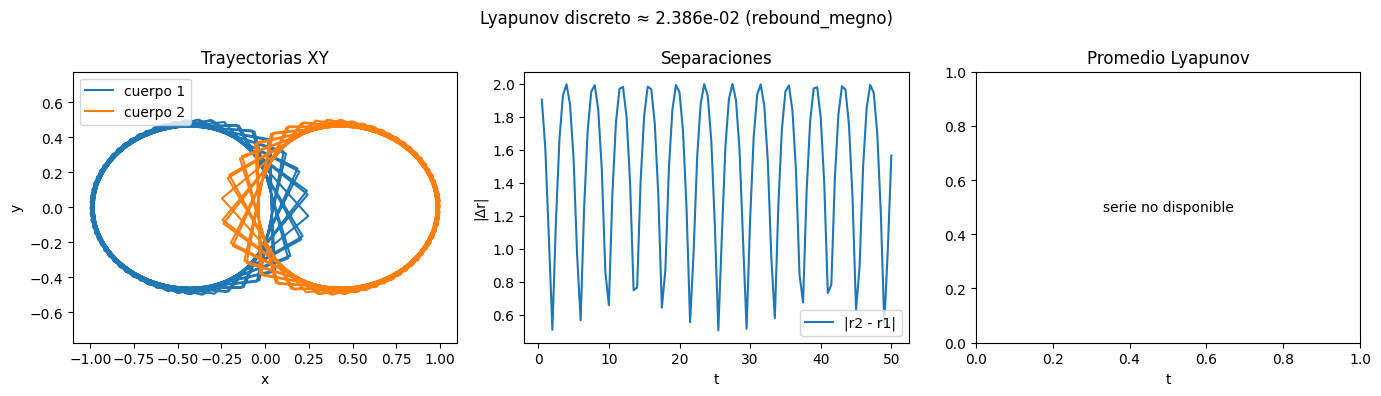

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# orbitas XY
axes[0].plot(traj[:, 0, 0], traj[:, 0, 1], label="cuerpo 1")
axes[0].plot(traj[:, 1, 0], traj[:, 1, 1], label="cuerpo 2")
if n_bodies == 3:
    axes[0].plot(traj[:, 2, 0], traj[:, 2, 1], label="cuerpo 3")
axes[0].set_title("Trayectorias XY")
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")
axes[0].axis("equal")
axes[0].legend()

# distancias relativas (entre cuerpo 1 y 2; amplía si hay tercero)
dist_12 = np.linalg.norm(traj[:, 1, 0:3] - traj[:, 0, 0:3], axis=1)
axes[1].plot(time, dist_12, label="|r2 - r1|")
if n_bodies == 3:
    dist_13 = np.linalg.norm(traj[:, 2, 0:3] - traj[:, 0, 0:3], axis=1)
    dist_23 = np.linalg.norm(traj[:, 2, 0:3] - traj[:, 1, 0:3], axis=1)
    axes[1].plot(time, dist_13, label="|r3 - r1|")
    axes[1].plot(time, dist_23, label="|r3 - r2|")
axes[1].set_title("Separaciones")
axes[1].set_xlabel("t")
axes[1].set_ylabel("|Δr|")
axes[1].legend()

# serie Lyapunov si está disponible
if series is not None:
    axes[2].plot(time[: series.size], series)
    axes[2].set_title("Promedio Lyapunov")
else:
    axes[2].text(0.5, 0.5, "serie no disponible", ha="center", va="center")
    axes[2].set_title("Promedio Lyapunov")
axes[2].set_xlabel("t")

fig.suptitle(f"Lyapunov discreto ≈ {lam:.3e} ({meta['impl']})")
plt.tight_layout()

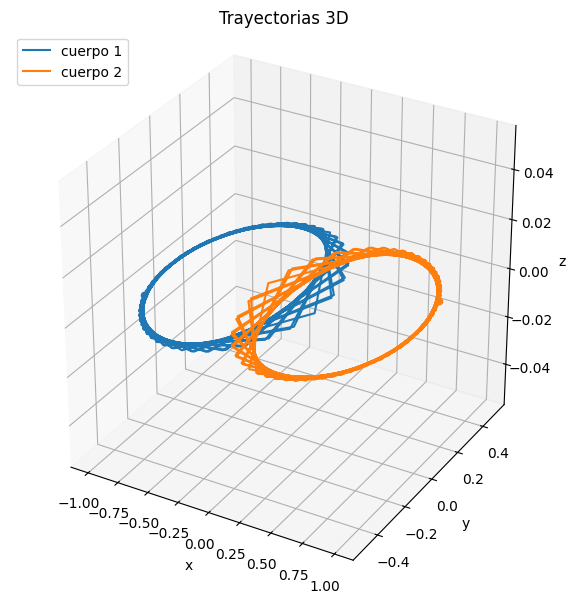

In [19]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401, solo asegura la proyección 3D

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

colors = ["tab:blue", "tab:orange", "tab:green"]
for j in range(n_bodies):
    r_xyz = traj[:, j, 0:3]
    ax.plot(r_xyz[:, 0], r_xyz[:, 1], r_xyz[:, 2], color=colors[j % len(colors)], label=f"cuerpo {j+1}")
    ax.scatter(r_xyz[0, 0], r_xyz[0, 1], r_xyz[0, 2], color=colors[j % len(colors)], marker="o")  # posición inicial

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_title("Trayectorias 3D")
ax.legend(loc="upper left")
ax.set_box_aspect([1, 1, 1])  # mantiene proporciones cúbicas

plt.tight_layout()
